github repository:
https://github.com/Pitwutz/DeepLearning_IrisDetection


# 1. Install Dependencies and Setup


In [3]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dropout,
    Dense,
    Reshape,
    Input,
    Flatten,
)
from tensorflow.keras.models import load_model, Sequential
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import VGG16, ResNet152V2

/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_60021/631737206.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load Data


### 2.1 Load Images


In [5]:
def load_data(
    data_type, content_type, version=None, aug_flag=None, load_val_labels_flag=False
):
    # Dynamic path adjustments
    version_part = f"_{version}" if version else ""
    aug_flag_part = f"_{aug_flag}" if aug_flag else ""

    # Determine content type and corresponding folder (images or labels)
    folder = "images" if content_type == "images" else "labels"
    file_pattern = "*.jpg" if content_type == "images" else "*.json"
    data_path_pattern = (
        f"data/{data_type}{version_part}{aug_flag_part}/{folder}/{file_pattern}"
    )
    # Create dataset
    data_files = tf.data.Dataset.list_files(data_path_pattern, shuffle=False)

    # Process based on content type
    if content_type == "images":
        data_files = data_files.map(load_image)
        data_files = data_files.map(lambda x: tf.image.resize(x, (250, 250)))
        data_files = data_files.map(lambda x: x / 255.0)
    elif content_type == "labels":
        if not load_val_labels_flag:
            data_files = data_files.map(
                lambda x: tf.py_function(load_labels, [x], [tf.float16])
            )
        else:
            data_files = data_files.map(
                lambda x: tf.py_function(load_val_labels, [x], [tf.float16])
            )

    return data_files


def load_labels(label_path):
    # Load JSON file
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)
    return [label["keypoints"]]


def load_image(image_path):
    # Load and decode an image file
    image = tf.io.read_file(image_path)
    return tf.image.decode_jpeg(image, channels=3)


def load_val_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)

    # Initialize default points for both eyes
    points_left = [0, 0]  # Default for LeftEye if not found
    points_right = [0, 0]  # Default for RightEye if not found

    # Loop through each shape to find the eyes by label
    for shape in label["shapes"]:
        if shape["label"] == "LeftEye" and shape["points"]:
            points_left = shape["points"][0]  # Get first point of LeftEye
        elif shape["label"] == "RightEye" and shape["points"]:
            points_right = shape["points"][0]  # Get first point of RightEye

    # Normalize the points by a fixed dimensiion used in the DataCollection notebook.
    keypoints = [
        points_left[0] / 460,
        points_left[1] / 460,
        points_right[0] / 460,
        points_right[1] / 460,
    ]

    # Return the keypoints in the structure assuming this mimics the missing 'keypoints' field
    return [keypoints]

In [6]:
train_images = load_data("train", "images", "3", "aug")

2024-04-28 13:32:20.219328: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-28 13:32:20.219353: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-28 13:32:20.219364: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-28 13:32:20.219714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 13:32:20.220019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
test_images = load_data("test", "images", "3", "aug")

In [8]:
val_images = load_data("val", "images", "3", "aug")

### 2.2 Prepare Labels


In [9]:
train_labels = load_data("train", "labels", "3", "aug")

In [10]:
train_labels.as_numpy_iterator().next()
# x left eye, y left eye, x right eye, y right eye

(array([0.3738, 0.1531, 0.    , 0.    ], dtype=float16),)

In [11]:
test_labels = load_data("test", "labels", "3", "aug")

In [12]:
# val_labels = load_data("val", "labels", load_val_labels_flag="load_val_labels")
val_labels = load_data("val", "labels", "3", "aug")

### 2.3. Combine Labels and Images


In [13]:
def setup_data_pipeline(images, labels, batch_size, shuffle):

    # Zipping datasets together
    train_dataset = tf.data.Dataset.zip((images, labels))

    # Shuffle the dataset if shuffle is provided as a number
    if isinstance(shuffle, int) and shuffle > 0:
        train_dataset = train_dataset.shuffle(shuffle)

    # Batch the dataset
    train_dataset = train_dataset.batch(batch_size)

    # Prefetch to improve speed of input pipeline
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset

In [14]:
train = setup_data_pipeline(train_images, train_labels, 128, 3400)

In [15]:
train.as_numpy_iterator().next()

(array([[[[0.2990588 , 0.3108235 , 0.43239215],
          [0.3019247 , 0.3136894 , 0.43525803],
          [0.30360782, 0.31537256, 0.43694118],
          ...,
          [0.44854116, 0.46422744, 0.5779529 ],
          [0.4532549 , 0.46894118, 0.5826667 ],
          [0.44933334, 0.4650196 , 0.5787451 ]],
 
         [[0.30693802, 0.31870273, 0.44027135],
          [0.30648002, 0.31824473, 0.43981335],
          [0.3044392 , 0.3162039 , 0.43777254],
          ...,
          [0.44705883, 0.4627451 , 0.5764706 ],
          [0.45248938, 0.46817565, 0.58190113],
          [0.45200002, 0.4676863 , 0.5814117 ]],
 
         [[0.3058745 , 0.3176392 , 0.43920782],
          [0.30331764, 0.31508234, 0.436651  ],
          [0.29564705, 0.30741176, 0.42898038],
          ...,
          [0.44745097, 0.46313724, 0.57686275],
          [0.45006284, 0.4657491 , 0.57947457],
          [0.45246267, 0.46814895, 0.5818745 ]],
 
         ...,
 
         [[0.26188236, 0.41482356, 0.8893333 ],
          [0.27581

In [16]:
test = setup_data_pipeline(test_images, test_labels, 128, 900)

In [17]:
val = setup_data_pipeline(val_images, val_labels, 128, 800)

### 2.4 View Samples


In [18]:
data_samples = train.as_numpy_iterator()

In [19]:
res = data_samples.next()

In [20]:
res

(array([[[[0.8134118 , 0.72713727, 0.6761569 ],
          [0.81792474, 0.72380704, 0.6767482 ],
          [0.82995296, 0.7240706 , 0.68093336],
          ...,
          [0.7798352 , 0.5994431 , 0.5484627 ],
          [0.7814117 , 0.6010195 , 0.5500391 ],
          [0.78039217, 0.6       , 0.54901963]],
 
         [[0.8043137 , 0.71803916, 0.6631372 ],
          [0.8177255 , 0.7275294 , 0.67262745],
          [0.8225647 , 0.7166823 , 0.67354506],
          ...,
          [0.77869016, 0.598298  , 0.5473176 ],
          [0.78608775, 0.6056956 , 0.5547152 ],
          [0.78431374, 0.6039216 , 0.5529412 ]],
 
         [[0.81905097, 0.7288549 , 0.67395294],
          [0.82878435, 0.72682357, 0.6758432 ],
          [0.8298823 , 0.7200784 , 0.6730196 ],
          ...,
          [0.77564704, 0.5952549 , 0.5442745 ],
          [0.7814117 , 0.6010195 , 0.5500391 ],
          [0.7779529 , 0.59756076, 0.5465804 ]],
 
         ...,
 
         [[0.98789805, 0.9609412 , 0.92156076],
          [0.99424

In [21]:
res[0].shape

(16, 250, 250, 3)

In [22]:
np.multiply(res[1][0][0], [250, 250, 250, 250])

array([116.27197266,  76.72119141, 229.4921875 ,  72.265625  ])

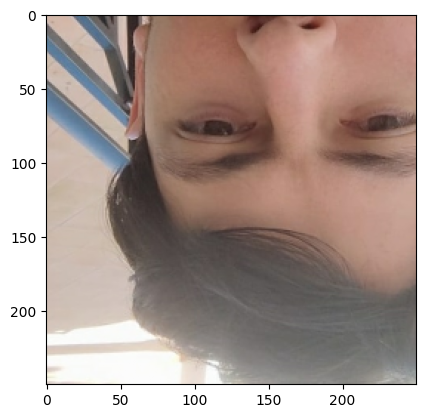

In [23]:
plt.imshow(res[0][0])

In [24]:
def plot_sample_images(start_idx, end_idx, image_samples, coordinates):
    """
    Plots a range of sample images with predicted coordinates marked.

    Parameters:
    start_idx (int): The starting index of the samples to be plotted.
    end_idx (int): The ending index of the samples to be plotted.
    image_samples (list or ndarray): The list or array of test sample images.
    coordinates (list or ndarray): The list or array of predicted coordinates.

    """
    ncols = end_idx - start_idx
    fig, ax = plt.subplots(
        ncols=ncols, figsize=(5 * ncols, 5)
    )  # Adjusted figsize to scale with number of columns
    for idx in range(start_idx, end_idx):
        # Create a writable copy of the sample image
        sample_image = image_samples[idx].copy()
        sample_coords = coordinates[idx]

        # Draw the circles on the image
        cv2.circle(
            sample_image,
            tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)),
            2,
            (255, 0, 0),
            -1,
        )
        cv2.circle(
            sample_image,
            tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)),
            2,
            (0, 255, 0),
            -1,
        )

        # Show the image
        ax[idx - start_idx].imshow(sample_image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


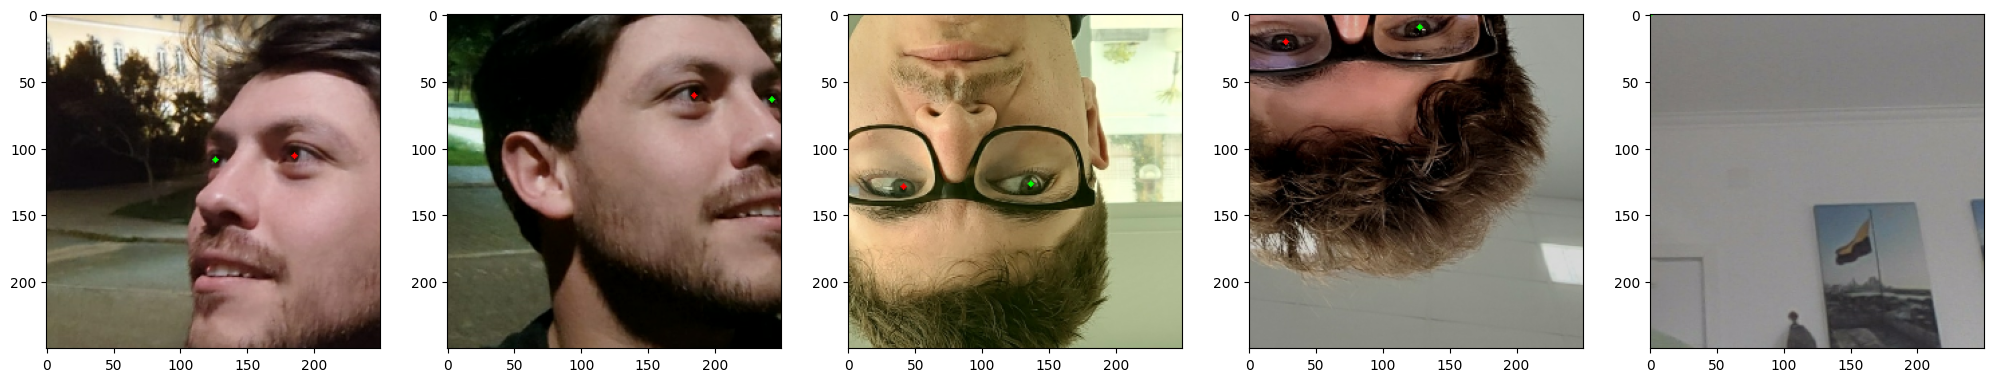

In [25]:
plot_sample_images(10, 15, res[0], res[1][0])

# 3. Build Model


## A. ResNet


### 1. Create Neural Network


In [27]:
model = Sequential(
    [
        Input(shape=(250, 250, 3)),
        ResNet152V2(include_top=False, input_shape=(250, 250, 3)),
        Conv2D(512, 3, padding="same", activation="relu"),
        Conv2D(512, 3, padding="same", activation="relu"),
        Conv2D(256, 3, 2, padding="same", activation="relu"),
        Conv2D(256, 2, 2, activation="relu"),
        Dropout(0.05),
        Conv2D(4, 2, 2),
        Reshape((4,)),
    ]
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 2. Setup Losses and Optimizer


In [29]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [30]:
model.compile(optimizer, loss)

### 3. Sense Check predictions


In [31]:
X, y = train.as_numpy_iterator().next()

In [32]:
X.shape

(16, 250, 250, 3)

In [33]:
scores = model.predict(X)

2024-04-28 13:32:47.670264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


In [34]:
scores

array([[-1.421386  ,  0.7746289 ,  0.58116597,  0.04076579],
       [-1.3189795 ,  0.27516335,  0.6029201 ,  0.6692766 ],
       [-1.8590634 ,  0.64050823,  0.65781844,  0.18880981],
       [-1.4452982 ,  0.02702823,  0.31067267,  0.9524102 ],
       [-2.0653446 , -0.05973375,  0.24138837,  0.9755899 ],
       [-1.9347554 , -0.07567792,  0.531755  ,  0.50389516],
       [-1.646469  ,  1.1785696 ,  0.9432512 ,  1.3834895 ],
       [-1.9427892 ,  0.1008555 ,  1.0173197 ,  0.10633382],
       [-2.2405648 ,  0.89408696,  0.72337013,  1.3675445 ],
       [-1.2926025 ,  0.1400869 ,  0.55536944, -0.13071567],
       [-1.0034572 ,  0.01443582,  0.6130186 ,  0.69886935],
       [-0.76509464, -0.03931423,  0.22701201,  0.32909074],
       [-0.92230225,  0.01272148,  0.41226137,  0.9858054 ],
       [-1.5018803 ,  0.49576887,  0.76545167,  1.170515  ],
       [-2.123501  ,  0.3562795 ,  0.06339712,  0.39283723],
       [-1.8308542 , -0.72571963, -0.04317306,  1.4596643 ]],
      dtype=float32)

### 4. Train the Model


In [35]:
# hist = model.fit(train, epochs=4, validation_data=val)

## B. VGG


### 1. Create Neural Network


In [36]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG-16 model without the top layer, adapted to your input size
base_model_vgg = VGG16(
    weights="imagenet", include_top=False, input_shape=(250, 250, 3))

# Freeze the layers of the base model to preserve the learned features
for layer in base_model_vgg.layers[:-2]:
    layer.trainable = False

for layer in base_model_vgg.layers[-2:]:
    layer.trainable = True

# Create the model with custom layers specifically for iris detection
model_vgg = Sequential(
    [
        base_model_vgg,
        Conv2D(96, 7, padding="same", activation="relu"),
        Conv2D(128, 5, padding="same", activation="relu"),
        MaxPooling2D(2),
        Conv2D(256, 3, padding="same", activation="relu"),
        MaxPooling2D(2),
        Conv2D(512, 2, padding="same", activation="relu"),
        MaxPooling2D(1),
        Flatten(),
        # Outputs normalized coordinates for the irisx
        Dense(512, activation="relu"),  # Second dense layer with 512 units
        Dropout(0.2),  # Dropout with a probability of 0.2
        Dense(128, activation="relu"),  # Second dense layer with 128 units
        Dropout(0.2),
        Dense(32, activation="relu"),  # Third dense layer with 128 units
        Dense(4, activation="linear"),
    ]
)

# model_vgg.summary()

### 2. Setup Losses and Optimizer


In [37]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

# Compile the model_vgg with an appropriate optimizer and loss function for regression
model_vgg.compile(optimizer=optimizer, loss=loss)

### 3. Train the model


In [38]:
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=5)

hist = model_vgg.fit(train, epochs=30, validation_data=val,
                     callbacks=[callback])

## C. Tuner Search


### 1. Tuner function


In [39]:
def build_model(hp):
    model_type = hp.Choice("model_type", ["VGG16", "ResNet152V2"])

    if model_type == "VGG16":
        base_model = tf.keras.applications.VGG16(
            include_top=False, weights="imagenet", input_shape=(250, 250, 3)
        )
    else:
        base_model = tf.keras.applications.ResNet152V2(
            include_top=False, weights="imagenet", input_shape=(250, 250, 3)
        )

    base_model.trainable = not hp.Boolean("freeze_layers")

    model = Sequential(
        [
            base_model,
            Conv2D(512, 3, padding="same", activation="relu"),
            MaxPooling2D(2, 2),
            Conv2D(512, 3, padding="same", activation="relu"),
            MaxPooling2D(2, 2),
            Conv2D(256, 3, padding="same", activation="relu"),
            Conv2D(256, 3, padding="same", activation="relu"),
            MaxPooling2D(2, 2),
            Dropout(
                hp.Float("dropout_rate", min_value=0.01, max_value=0.05, step=0.01)
            ),
            Dense(
                hp.Int("dense_units", min_value=32, max_value=512, step=32),
                activation="relu",
            ),
            Conv2D(128, 3, padding="same", activation="relu"),
            Conv2D(64, 3, padding="same", activation="relu"),
            Conv2D(4, 3, padding="same"),
            Reshape([-1]),  # Automatically compute the necessary shape
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(
            hp.Float("learning_rate", min_value=0.0001, max_value=0.01, sampling="LOG")
        ),
        loss="mean_squared_error",
    )

    return model


tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=7,
    executions_per_trial=1,
    directory="my_dir",
    project_name="model_tuning",
)

Reloading Tuner from my_dir/model_tuning/tuner0.json


### 2. Execute tuner function


In [40]:
train_data, val_data = train, val

tuner.search(train_data, epochs=5, validation_data=val_data)


Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
ResNet152V2       |ResNet152V2       |model_type
False             |True              |freeze_layers
0.04              |0.04              |dropout_rate
64                |64                |dense_units
0.00010459        |0.0017775         |learning_rate



Epoch 1/5
207/207 [==============================] - 1006s 5s/step - loss: 0.0415 - val_loss: 0.0310
Epoch 2/5
  7/207 [>.............................] - ETA: 20:13 - loss: 0.0254

: 

### 3. Build tuned model


In [ ]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Re-train the best model
hist = best_model.fit(train_data, epochs=5, validation_data=val_data)

NameError: name 'tuner' is not defined

# 4. Review Performance


### 4.1 View Loss Plots


In [ ]:
hist.history

{'loss': [3.59428334236145,
  0.05803845450282097,
  0.043373581022024155,
  0.03364357724785805,
  0.030716031789779663,
  0.026621025055646896,
  0.02246912196278572,
  0.020609933882951736],
 'val_loss': [1.1850643157958984,
  0.09675299376249313,
  0.06696769595146179,
  0.09008098393678665,
  0.06304404139518738,
  0.06086735054850578,
  0.06306864321231842,
  0.06551752984523773]}

In [1]:
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val loss")
plt.suptitle("Loss")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### 4.2. Make Predictions on Test


1/1 [==============================] - 1s 529ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


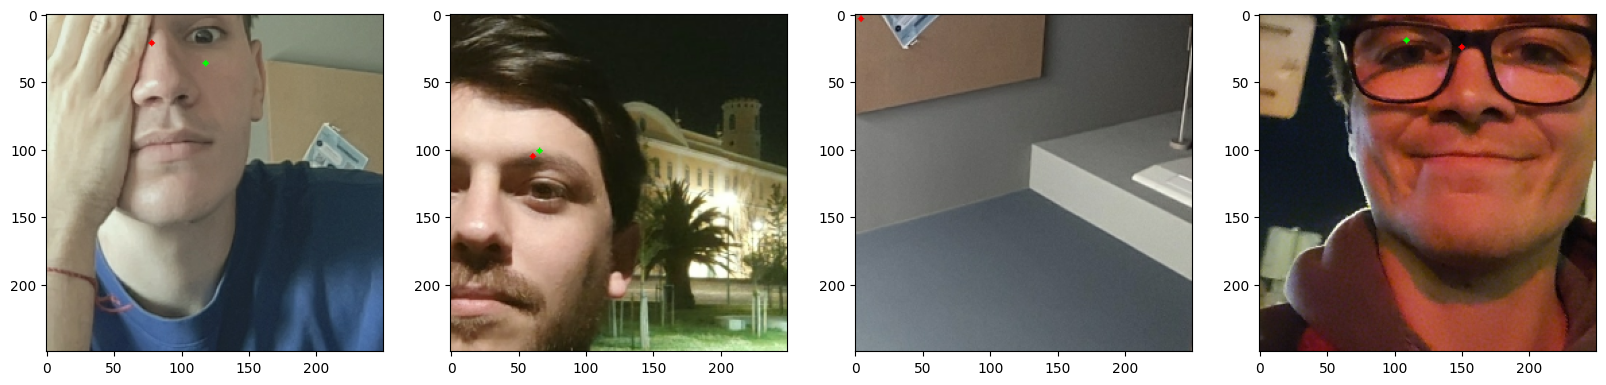

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
plot_sample_images(0, 4, test_sample[0], yhat)

# 5. Save the Model


### 1. saving the model locally


In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "eyetrackerresnet{}.h5".format(timestamp)

In [ ]:
model.save(filename)

/Users/peterfalterbaum/anaconda3/envs/ProgrammingDS/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 2. load a trained model


In [ ]:
model = load_model("eyetrackerresnet20240422_205952.h5")

In [ ]:
model.predict(test_sample[0])

1/1 [==============================] - 5s 5s/step


array([[-0.01595877, -0.02694788,  0.06226623,  0.0225804 ],
       [ 0.44576833,  0.37046853,  0.39235884,  0.29783845],
       [ 0.01832629,  0.02076698, -0.00251424, -0.00230052],
       [ 0.220974  ,  0.23545521,  0.4078232 ,  0.43336695],
       [ 0.20460549,  0.64565766,  0.28342614,  0.60599875],
       [ 0.03083288,  0.27387962,  0.08495668,  0.1826602 ],
       [ 0.01428997,  0.32917044,  0.14770171,  0.34455526],
       [-0.0121689 , -0.02231944,  0.05234042,  0.0180831 ],
       [ 0.12549408, -0.01007451,  0.16232157,  0.11530594],
       [-0.00085108, -0.00136209,  0.06009679,  0.02534008],
       [-0.00075612,  0.00130264,  0.05813616,  0.02853411],
       [-0.00890324, -0.02287058,  0.05417106,  0.01394499],
       [ 0.65833634,  0.40241167,  0.7159685 ,  0.44566643],
       [ 0.35158968,  0.5557193 ,  0.50401634,  0.65830475],
       [ 0.3101913 ,  0.13408192,  0.5786302 ,  0.35086623],
       [ 0.1747661 ,  0.18116194,  0.5269819 ,  0.5201608 ]],
      dtype=float32)

### 3. view predictions on test data


In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
plot_sample_images(0, 4, test_sample[0], yhat)

### 4. final model


The final model was uploaded to onedrive as it is too large to upload on github.
The model was trained on the following parameters:

```
learning rate = 0.001
optimiser = adam
loss = Mean Squared Error
batch size = 32
epochs = 20
```

link: https://1drv.ms/f/s!Ap9X0H2ysg0VhMJD4Jk1i-jLzA-WBA?e=R5WpDq
